# Travaux pratiques- Filtrage basé graphe et problèmes inverses sur graphes avec Pygsp

Adaptée de la version du TP du cours [Network Tour of Data Science] donné à l'Ecole Polytechnique Federale de Lausanne (EPFL) : https://github.com/mdeff/ntds_2019

[Mira Rizkallah](https://www.ls2n.fr/annuaire/Mira%20RIZKALLAH/), [LS2N SIMS](https://sims.ls2n.fr)

PyGSP est une librairie populaire pour le traitement du signal sur graphe conçue pour Python. Dans ce Notebook, on apprendra à manipuler des graphes et les signaux résidant sur ces graphes. 

Ceci est un tutoriel sur [PyGSP] (https://github.com/epfl-lts2/pygsp. La librairie PyGSP facilite une grande variété d'opérations sur les graphes, comme le calcul de leur bases de transformée de Fourier, le filtrage ou l'interpolation de signaux, la visualisation de graphes, de signaux et de filtres. La librairie comprend une large gamme de graphes largement utilisés et différents filtres. Outre les modèles prédéfinis, vous pouvez facilement créer un graphe personnalisé en définissant sa matrice d'adjacence ou de poids, et vous pouvez également concevoir des filtres personnalisés en définissant un ensemble de fonctions dans le domaine spectral du graphe.

Avant le 22 février, le notebook modifié par groupe doit être rendu avec: 
- un exposé clair et une interprétation des résultats obtenus à chaque étape
- les réponses aux questions posées avec les codes demandés. 
- il est important que les figures (que vous montrez avec plot) soient lisibles avec un titre et des labels pour les deux axes: x et y.

In [31]:
%matplotlib inline

## 1- Filtrage basée graphe

In [32]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting

Un signal $\mathbf{x}$ est filtré sur un graphe avec l'équation suivante: 
$$\mathbf{y} = \mathbf{U} \hat{g}(\mathbf{\Lambda}) \mathbf{U}^\intercal \, \mathbf{x} = \hat{g}(\mathbf{U} \mathbf{\Lambda} \mathbf{U}^\intercal) \, \mathbf{x} = \hat{g}(\mathbf{L}) \, \mathbf{x},$$

avec $\hat{g}(\cdot)$, le noyau de filtre défini dans le domaine spectral par une fonction des valeurs propres du laplacien (fréquences). On peut séparer l'opération du filtrage en $3$ étapes:

1. On obtient la representation spectrale du signal sur le graphe par GFT (transformée de Fourier): 
$\hat{\mathbf{x}} = \mathbf{U}^\intercal \, \mathbf{x}$.
2. On filtre le signal dans le domaine spectral en multipliant chaque coefficient transformé par le. coefficient correspondant du filtr, i.; elementwise multiplication:
$\hat{\mathbf{y}} = \hat{g} \odot \hat{\mathbf{x}} = \hat{g}(\mathbf{\Lambda})\hat{\mathbf{x}} $
3. On retourne dans le domaine spatial par IGFT (transformée de fourier inverse):
$\mathbf{y} = \mathbf{U}\hat{\mathbf{y}}$


On peut également considérer le filtrage comme une multipplication entre une matrice et un vecteur: 
entre l'opérateur de filtrage $\hat{g}(\mathbf{L})$, et le signal $\mathbf{x}$.
Le module [`filters`](https://pygsp.readthedocs.io/en/stable/reference/filters.html) de la librairie PyGSP inclue une implementation des filtres basés graphes les plus utilisés.

### 4.0 Un filtrage basique: Brick-wall low-pass filter

2022-02-20 15:17:27,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.5900200641113513


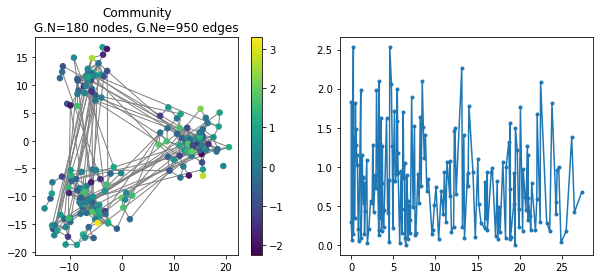

In [33]:
communities = [40, 80, 60]
G = graphs.Community(N=180, Nc=3, comm_sizes=communities) 
f = np.random.normal(size=G.N)
G.compute_fourier_basis()
f_hat = G.gft(f)
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
G.plot_signal(f, vertex_size=30, ax=axes[0]) 
axes[1].plot(G.e, np.abs(f_hat), '.-')

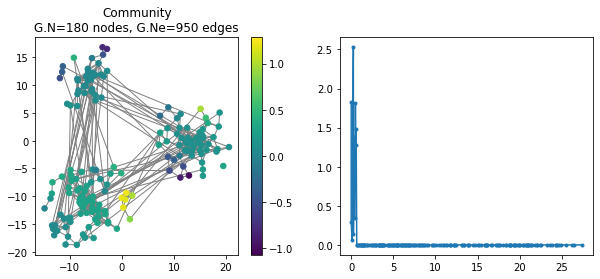

In [34]:
import copy
fb_hat = copy.deepcopy(f_hat)
fb_hat[10:] = 0 # this corresponds to an ideal brick-wall low-pass filtering 
fb = G.igft(fb_hat)

G.compute_fourier_basis()
fb_hat = G.gft(fb)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(fb, vertex_size=30, ax=axes[0]) 
axes[1].plot(G.e, np.abs(fb_hat), '.-')

- Visualiser les deux signaux: f et fb sur le graphe G. Que remarquez-vous? 

**Réponse :** On remarque que les coefficients de la transformée de Fourier du signal fb sont tous nuls à partir d'un certain rang.    
Le signal fb est le résultat de l'application d'un filtre passe bas au signal f.

### 4.1 Un filtrage simple: heat diffusion (diffusion de la chaleur)

Un autre type de filtrage passe-bas est avec un "heat kernel" (qui représente l'évolution de la température égale à une unité de chaleur en un point au temps initial)
$h(\lambda)$ est défini comme: $$h_\tau(\lambda)=\exp^{-\tau\lambda}.$$ qui est une exponentielle décroissante avec un paramétre réglable $\tau$.

On peut changer la localisation du filtre dans le domaine spatial (domaine des noeuds) en utilisant la fonction `filters.localize()`.

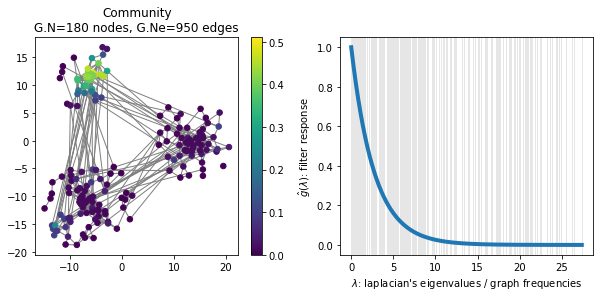

In [35]:
tau = 10
delta = 15
g = filters.Heat(G, tau) # the heat kernel defined via the graph spectral domain
s = g.localize(delta) # the heat kernel localised at a particular node in the vertex domain 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(s, vertex_size=30, ax=axes[0])
g.plot(ax=axes[1])

On peut voir que dans le domaine spectral du graphe, le filtre pénalise plus les hautes fréquences (les plus grandes valeurs propres). Ce filtre peut être visualisé dans le domaine spatial (le domaine des noeuds) aussi, en le localisant à un noeud particulier. Ceci correspond à appliquer le filtre à un signal particulier qui est: la fonction de Kronecker i.e., ayant la valeur $1$ sur le noeud choisi and $0$ ailleurs. 

- Calculer le signal filtré $f_{heat}$, résultat du filtrage de $f$ par le filtre $g$ en utilisant la fonction `filters.filter()`,
- Vérifier que localiser un filtre sur un noeud particulier est équivalent à appliquer le même filtre à la fonction de Kronecker correspondante.
- Visualiser le signal original $f$ , the signal filtré $f_{brick}$ avec le filtre passe-bas "brick-wall" , et the signal filtré $f_{heat}$ avec le filtre "heat kernel" sur le graphe. Comparer les deux résultats. 

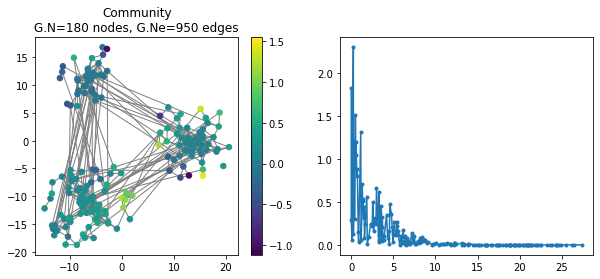

In [36]:
f_heat = g.filter(f)

f_heat_hat = G.gft(f_heat)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(f_heat, vertex_size=30, ax=axes[0]) 
axes[1].plot(G.e, np.abs(f_heat_hat), '.-')

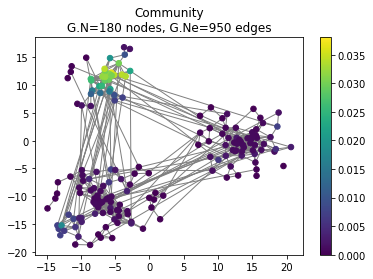

In [37]:
kronecker = np.zeros(G.N)
kronecker[delta] = 1
s_2 = g.filter(kronecker)
G.plot_signal(s_2, vertex_size=30)

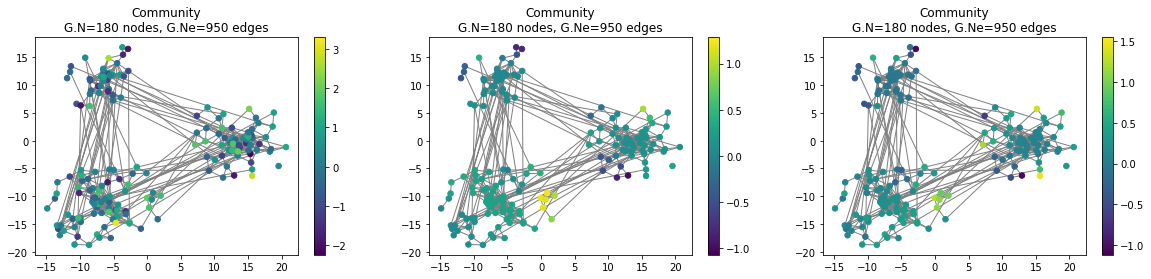

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

G.plot_signal(f, vertex_size=30, ax=axes[0]) 
G.plot_signal(fb, vertex_size=30, ax=axes[1]) 
G.plot_signal(f_heat, vertex_size=30, ax=axes[2]) 

On voit bien l'équivalence entre localiser un filtre sur un noeud particulier et appliquer le même filtre à la fonction de Kronecker correspondante.

On veut maintenant visualiser la diffusion sur un graphe en génerant une banque de filtres "heat kernel" avec différentes valeurs de $\tau$:

Pour différentes valeurs de $\tau = [5, 20, 100]$ : 
- Créer le filtre specialement construit sur le spectre du graphe G avec la valeur de $tau$ . 
- Appliquer le filtrage passe-bas défini ci-dessus sur le signal $s$ avec la méthode d'approximation de Chebychev.
- Visualiser le signal filtré ainsi que le filtre (dans le domaine spectral du graphe $G$

Pour plus de détails sur les fonctions, je vous invite de regarder la documentation: https://pygsp.readthedocs.io/en/stable/reference/filters.html

Modifier le code suivant pour inclure le processus du filtrage. 

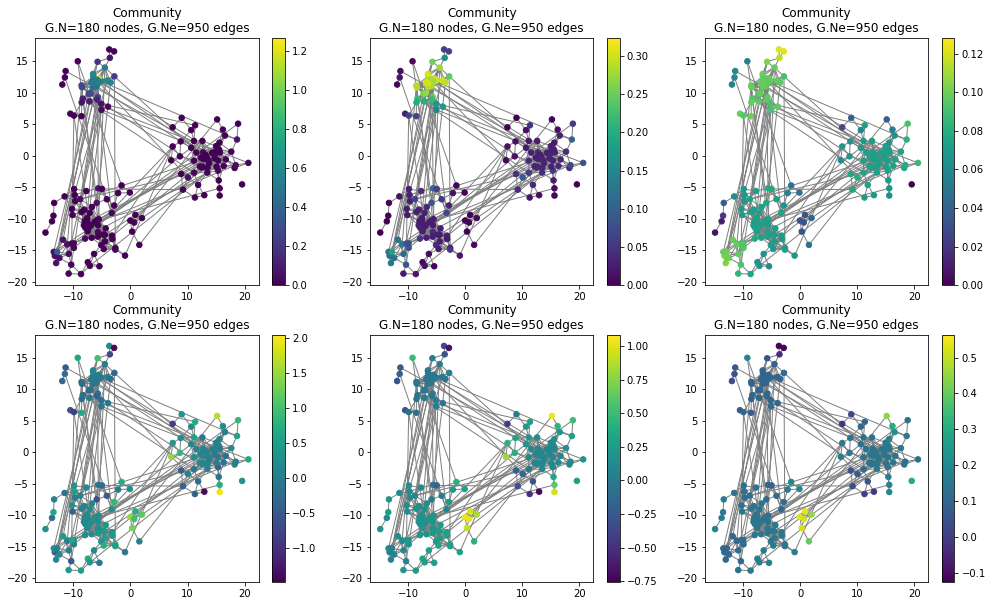

In [39]:
fig = plt.figure(figsize=(17, 10))

delta = 15
taus = [5, 20, 100]
for i in range(len(taus)):
    tau = taus[i] 
    g = filters.Heat(G, tau) # the heat kernel defined via the graph spectral domain
    s = g.localize(delta) # the heat kernel localised at a particular node in the vertex domain 

    ax = fig.add_subplot(2, len(taus), i+1)
    G.plot_signal(s, vertex_size=30, ax=ax)
    
    ax = fig.add_subplot(2, len(taus), i+4)
    f_cheby = g.filter(f, method='chebyshev')
    G.plot_signal(f_cheby, vertex_size=30, ax=ax)

On peut aussi créer un filtre personnalisé en définissant la fonction $g(\lambda)$ and en appelant la fonction `filters.Filter()`:

In [40]:
tau = 1
def g(x):
    return 1. / (1. + tau * x)
g = filters.Filter(G, g)

## 2- Problèmes inverses sur graphes: la régularisation de Tikhonov

## 2.1 Débruitage sur graphe

Le débruitage est un problème classique de traitement de signal et d'image ou on cherche à se débarrasser du bruit existant dans le signal observé. Le problème de débruitage d'un signal sur un graphe peut etre formulé par le problème d'optimisation suivant:
$$ min (||y−x||^2 +\alpha x^T L x), x \in R^N (1)$$ 

Avec $y$ le signal bruité observé sur le graphe G. L'optimisation cherche un signal $x$ qui est proche de $y$, et en même temps qui est "smooth" (lisse) sur the graphe. Le paramètre de régularisation $\alpha$ contrôle le compromis entre la fidélité aux données observées et l'à priori de "smoothness" sur le graphe.  La solution peut donc etre considérée comme une version débruitée du signal observé sur le graphe

- Montrer que la solution du problème d'optimisation précédent peut etre interprété comme l'application d'un filtre passe-bas sur le signal bruité observé. Vous pouvez chercher sur The Matrix Cookbook (http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=3274) pour trouver les détails de la dérivation sur des matrices. 

On obtient la solution $x^* = (\alpha L + I)^{-1}y$
Cette solution correspond bien à l'application d'un filtre sur le signal bruité $y$.

- Implémenter la solution de l'équation (1) via les étapes suivantes:
1. Construire un graphe de multi-capteurs en utilisant la classe `pygsp.graphs.Sensor` de PyGSP, et calculer le laplacien du graphe.
2. Définir un signal lisse sur le graphe ,e.g une combinaison linéaire des 5% premiers eigenvecteurs du laplacien. 
3. Ajouter du bruit gaussien (avec une variance approprié) au signal "smooth", afin d'obtenir le signal observé bruité;
4. Définir le filtre passe-bas avec une valeur de $\alpha$, and appliquer le au signal bruité, pour obtenir le signal débruité. Visualiser les trois signaux  (le ground-truth, le bruité, et le débruité) sur le graphe et comparer les.
5. Répéter avec plusieurs valeurs de $\alpha$. Quel est l'impact de la valeur de $\alpha$ sur le signal après débruitage? Pourriez-vous trouver une valeur optimale de $\alpha$ qui minimises l'erreur entre le signal original et le signal après débruitage? 

In [41]:
N = 100
G = graphs.Sensor(N)

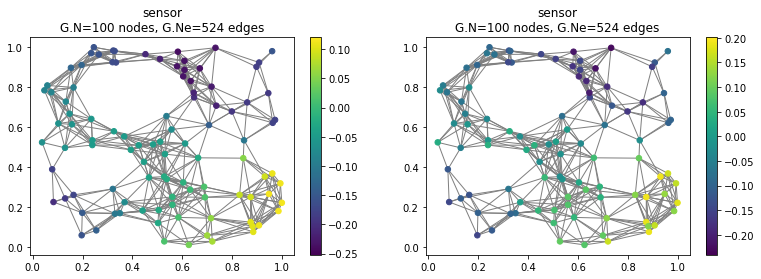

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

taille = int(np.round(N*0.05))
eig_val, U = sparse.linalg.eigsh(G.L, k=taille, which='SM')
coef = np.random.rand(taille)
x = (U * coef).sum(axis=1)

y = x + 0.1 * np.random.rand(x.shape[0])

G.plot_signal(x, vertex_size=30, ax=axes[0]) 
G.plot_signal(y, vertex_size=30, ax=axes[1]) 

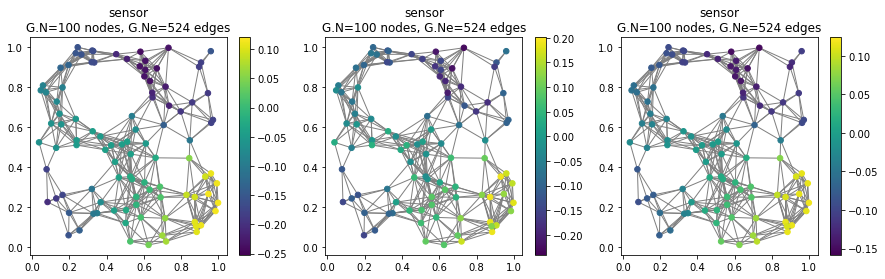

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

def debruitage(y, alpha):
    x_sol = np.linalg.inv(np.eye(y.shape[0]) + alpha * G.L) @ y
    return np.array(x_sol.T).ravel()

x_sol = debruitage(y, 1)

G.plot_signal(x, vertex_size=30, ax=axes[0]) 
G.plot_signal(y, vertex_size=30, ax=axes[1]) 
G.plot_signal(x_sol, vertex_size=30, ax=axes[2]) 

1.6466321726296745e-08

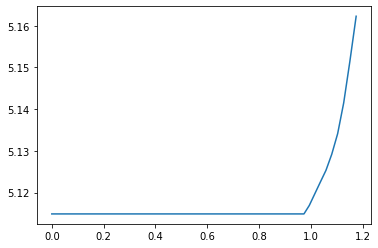

In [44]:
alphas = np.logspace(-9, 0.07, 1000)
err = []

for alpha in alphas:
    x_sol = debruitage(y, alpha)
    e = np.sum(np.abs(x - x_sol))
    err.append(e)
    
plt.plot(alphas, err)

alpha_opti = alphas[np.argmin(err)]
alpha_opti

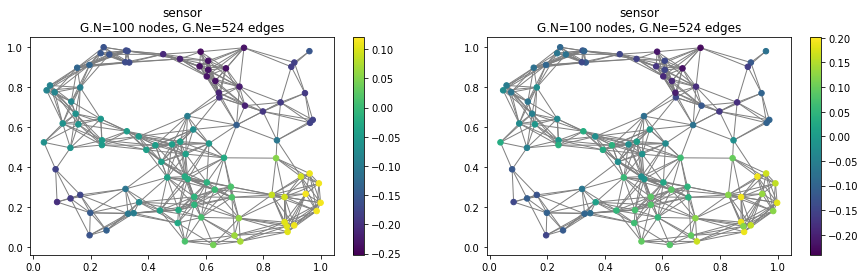

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

x_sol = debruitage(y, alpha_opti)

G.plot_signal(x, vertex_size=30, ax=axes[0]) 
G.plot_signal(x_sol, vertex_size=30, ax=axes[1]) 

## 2.2 Interpolation (inpainting) sur graphe

L'interpolation est un autre problème inverse classique du traitement du signal et de l'image ou on cherche à compléter les valeurs inconnues d'un signal partiellement observé. Une application typique de l'interpolation est l'inpainting des images, ou on cherche à retrouver les valeurs inconnues de pixels. L'interpolation pour un signal sur un graphe peut etre formulée par le problème suivant:
$$min (||y − Mx||^2 +\alpha x^T L x), x \in R^N (2) $$ 
avec $y$ le signal partiellement observé sur le graphe (avec des valeurs inconnus à $0$), et $M$ une matrice diagonale avec $M(i,i) = 1$, si la valeur du signal $y(i)$ est connue et observée, et $M(i,i) = 0$, si $y(i)$ est inconnue.
L'optimisation dans l'équation (2) essaie de trouver un signal $x$ qui correspond aux valeurs observées dans $y$, et qui est en même temps "smooth" sur le graphe. Le paramètre de régularisation $\alpha$ contrôle le compromis entre la fidélité aux données observés (data fidelity term) et le prior de "smoothness" du signal $x$ (smoothness prior). La solution de ce problème peut etre donc considéré comme le signal interpolé avec les valeurs non observés retrouvées. 

- Implémenter la solution à l'équation (2) via les étapes suivantes:
1. Construire un graphe de multi-capteurs en utilisant la classe `pygsp.graphs.Sensor` de PyGSP, et calculer le laplacien du graphe. (choisir le nombre de noeuds entre 50 et 500 noeuds)
2. Définir un signal lisse sur le graphe,e.g une combinaison linéaire des 5% premiers eigenvecteurs du laplacien. 
3. Échelonner les valeurs du signal entre 0 et 1. (pour que vous puissiez voir la différence entre les valeurs connues et inconnues);
4. Choisir Alétoirement $p = 50\%$ des valeurs du signal et les mettre à $0$, afin d'obtenir le signal partiellement observé;
5. Résoudre l'équation (2) (soit en appliquant directement la solution du cours et remplaçant M par une matrice diagonale $(I,0; 0, 0)$, soit en utilisant `np.linalg.solve()`), pour obtenir le signal interpolé (inpainted signal); Comparer les trois signaux: l'original, le partiellement observé, et le signal après inpainting. 
6. Répéter l'expérience avec différentes valeurs de $p$ and $\alpha$. Quel est l'impact des valeurs $p$ et $\alpha$ sur le signal arpès inpainting? À votre avis, jusqu'à quelle valeur de $p$, est-ce toujours possible de récupérer raisonnablement le signal interpolé? 

- En remplaçant $M$ par une matrice diagonale $(I,0; 0, 0)$ ou $I$ est la matrice identité, dériver à la main la solution du problème d'optimisation de l'équation (2). Quel interprétation pourriez-vous apporter à cette solution? (Vous pouvez vous appuyer sur The Matrix Cookbook http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=3274 pour le calcul de dérivé sur des matrices)

In [46]:
N = 300
G = graphs.Sensor(N)

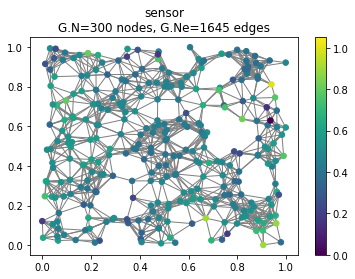

In [47]:
taille = int(np.round(N*0.3))
eig_val, U = sparse.linalg.eigsh(G.L, k=taille, which='SM')
coef = np.random.rand(taille)
x = (U * coef).sum(axis=1)
x = (x - np.min(x)) / (np.max(x) - np.min(x))

G.plot_signal(x, vertex_size=30) 

plt.show()

In [48]:
import random

p=0.5
ind = random.sample(range(x.shape[0]), int(x.shape[0]*p))
diag = np.array([1] * x.shape[0])
diag[ind] = 0
M = np.diag(diag)

y = copy.deepcopy(x)
y[ind] = 0

In [49]:
def interpolation(y, M, alpha):
    x_sol = np.linalg.inv(M.T @ M + alpha * G.L) @ M.T @ y
    return np.array(x_sol.T).ravel()

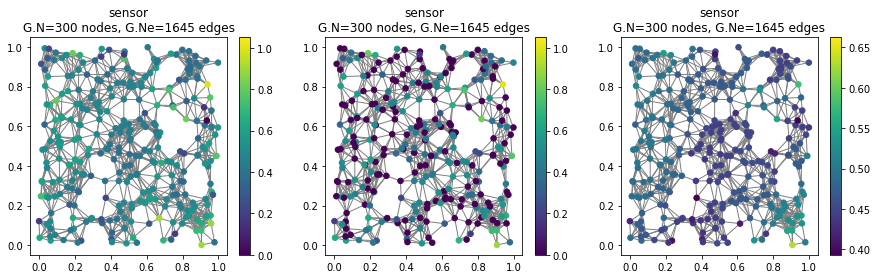

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

x_sol = interpolation(y, M, 1)

G.plot_signal(x, vertex_size=30, ax=axes[0]) 
G.plot_signal(y, vertex_size=30, ax=axes[1]) 
G.plot_signal(x_sol, vertex_size=30, ax=axes[2]) 

plt.show()

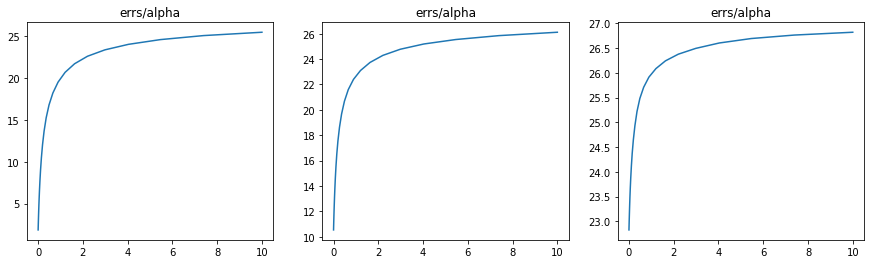

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ps = [0.1, 0.5, 0.9]
alphas = np.logspace(-12, 1, 100)
i=0

for p in ps:
    ind = random.sample(range(x.shape[0]), int(x.shape[0]*p))
    diag = np.array([1] * x.shape[0])
    diag[ind] = 0
    M = np.diag(diag)
    err = []
    y = copy.deepcopy(x)
    y[ind] = 0
    for alpha in alphas:
        x_sol_interp = interpolation(y, M, alpha)
        e = np.sum(np.abs(x - x_sol_interp))
        err.append(e)
        
    axes[i].plot(alphas, err)
    axes[i].set_title('errs/alpha')
    i+=1


## 2.3 Application sur des images 2D

• Appliquer des deux méthodes précédentes sur une image de votre choix. Hints:

1. Une image peut être vue comme un graphe particulier: la grille régulière 2D. Ce graphe peut etre généré en utilisant la classe `pygsp.graphs.Grid2d`;
2. Essayer une version grayscale d'une image avec une résolution spatiale basse, e.g., (64 x 64) or (128 x 128). 

Afin de lire et écrire des images, vous pouvez utiliser la librairie Python Imageio (https://imageio.github.io).

`conda : conda install -c conda-forge imageio`

`pip: pip install imageio`

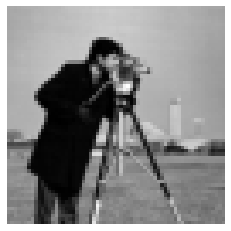

In [70]:
import skimage.io as io
from skimage.transform import resize

image = io.imread('Cameraman_mod.jpg', as_gray=True)
image = resize(image, (64, 64), anti_aliasing=True)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

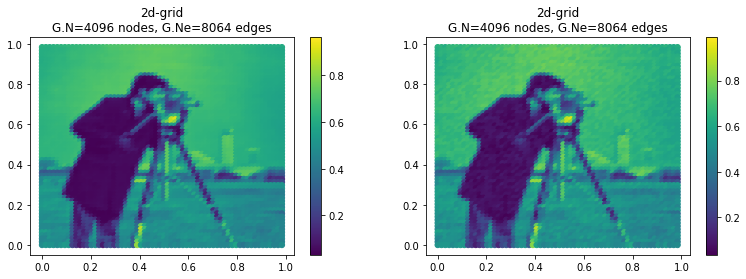

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

N = 64
G = graphs.Grid2d(N, N)

image = image.reshape(N*N, -1)

image_bruitée = image + 0.05 * np.random.rand(N * N, 1)
image_bruitée[image_bruitée > 1] = 1
image_bruitée[image_bruitée < 0] = 0

G.plot_signal(image, vertex_size=30, ax=axes[0]) 
G.plot_signal(image_bruitée, vertex_size=30, ax=axes[1]) 

In [91]:
def debruitage(G, y, alpha):
    x_sol = np.linalg.inv(np.eye(y.shape[0]) + alpha * G.L) @ y
    return np.array(x_sol.T).ravel()

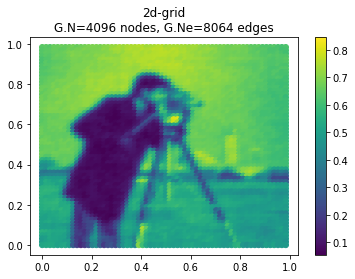

In [96]:
image_sol = debruitage(G, image_bruitée, 0.3)
G.plot_signal(image_sol, vertex_size=30) 